In [8]:
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import display, HTML

display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
plt.style.use("dark_background")

In [2]:
root_dir = ".."

In [3]:
admin = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
admin.geometry = admin.geometry.boundary
admin.geometry = admin.geometry.simplify(tolerance=0.1)

In [4]:
edges = gpd.read_parquet(os.path.join(root_dir, "results/flow_allocation/edges_with_flows.gpq"))
edges[edges.volume_tons != 0]

,from_id,to_id,from_iso_a3,to_iso_a3,mode,cost_USD_t,geometry,value_kusd,volume_tons
572,road_thailand-latest_9_1654,rail_thailand-latest_9_2,THA,THA,road_rail,5.0,"LINESTRING (99.20162 9.12104, 99.20061 9.12588)",3.331656,5.339141
573,road_thailand-latest_9_2009,rail_thailand-latest_9_3,THA,THA,road_rail,5.0,"LINESTRING (99.23042 9.10415, 99.23311 9.10721)",103.838205,60.445111
574,road_thailand-latest_9_2669,rail_thailand-latest_9_4,THA,THA,road_rail,5.0,"LINESTRING (99.25600 9.05591, 99.25385 9.05877)",63.632485,34.653723
603,road_thailand-latest_16_53,rail_thailand-latest_16_1,THA,THA,road_rail,5.0,"LINESTRING (100.31154 7.23790, 100.32446 7.23792)",31.352220,18.224139
604,road_thailand-latest_17_3272,rail_thailand-latest_17_0,THA,THA,road_rail,5.0,"LINESTRING (99.36223 8.80126, 99.36260 8.80187)",269.083200,149.140314
...,...,...,...,...,...,...,...,...,...
611860,GID_0_IND,port777_land,IND,IND,imaginary,0.0,"LINESTRING (69.62202 22.76297, 80.22113 21.78893)",158203.945506,92034.199021
612034,GID_0_KHM,port535_land,KHM,KHM,imaginary,0.0,"LINESTRING (103.52746 10.67900, 105.13276 12.5...",28197.925418,16013.482221
612119,GID_0_MMR,port1086_land,MMR,MMR,imaginary,0.0,"LINESTRING (96.21278 16.71605, 95.92710 19.25866)",97730.673076,55542.653659
612141,GID_0_SGP,port1182_land,SGP,SGP,imaginary,0.0,"LINESTRING (104.03453 1.35826, 103.82401 1.34506)",329.232385,525.777762


Text(0, 0.5, 'Frequency')

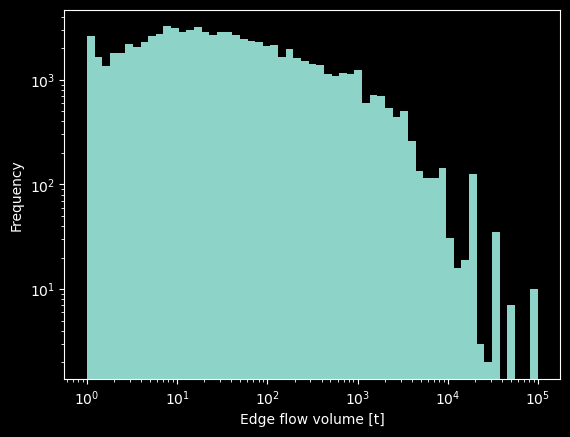

In [10]:
f, ax = plt.subplots()
min_non_zero = edges[edges.volume_tons != 0].volume_tons.min()
min_base_10_exp = int(np.floor(np.log10(min_non_zero)))
max_base_10_exp = int(np.ceil(np.log10(edges.volume_tons.max())))
ax.hist(
    edges.volume_tons,
    bins=np.logspace(
        min_base_10_exp,
        max_base_10_exp,
        60
    )
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Edge flow volume [t]")
ax.set_ylabel("Frequency")

(2.98, 22.59)

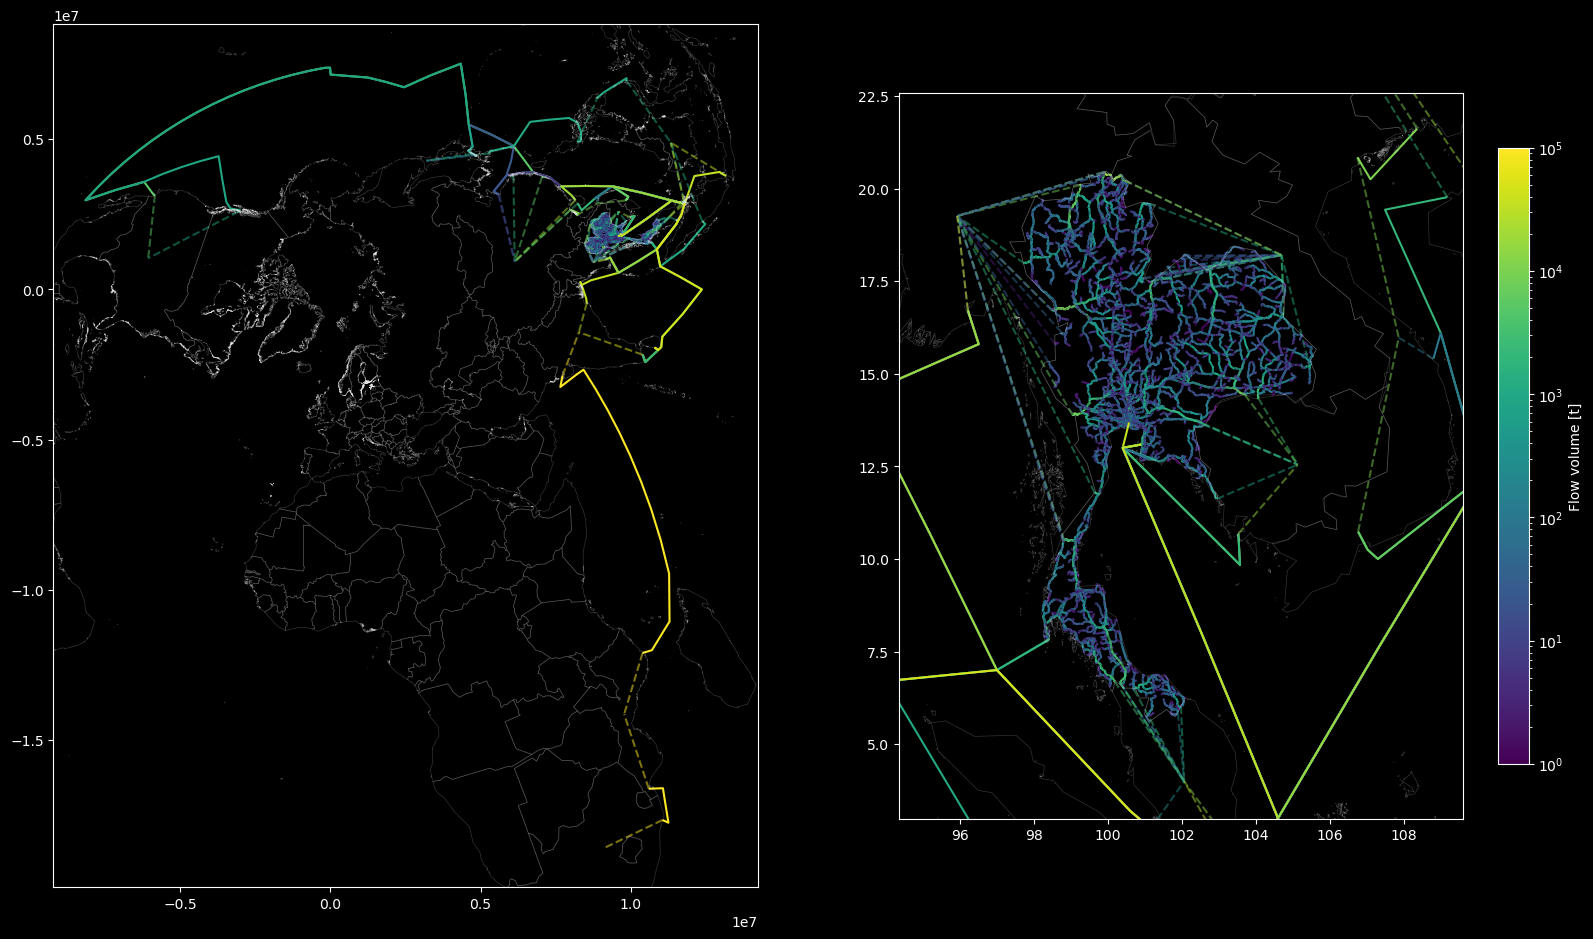

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))

to_plot = edges[edges.volume_tons != 0]
not_imaginary_mask = to_plot["mode"] != "imaginary"

norm = LogNorm(10**min_base_10_exp, 10**max_base_10_exp)

to_plot[not_imaginary_mask].to_crs(epsg=3995).plot("volume_tons", ax=ax1, norm=norm)
to_plot[~not_imaginary_mask].to_crs(epsg=3995).plot("volume_tons", ax=ax1, norm=norm, ls="--", alpha=0.5)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
admin.to_crs(epsg=3995).plot(ax=ax1, lw=0.5, alpha=0.2)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

to_plot[not_imaginary_mask].plot("volume_tons", ax=ax2, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t]"})
to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax2, norm=norm, ls="--", alpha=0.5)
admin.plot(ax=ax2, lw=0.5, alpha=0.2)
ax2.set_xlim(94.35, 109.59)
ax2.set_ylim(2.98, 22.59)